In [ ]:
from vc_clothes_dataset_w_faces import VCClothesDataset, build_transforms
from face_dataset import FaceDataset
from face_detector import FaceDetector
from face_feature_extractor import FaceFeatureExtractor
# from face_feature_extractor_wrapper import FaceReIDTrainWrapper
# from trainer import Trainer

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

c:\25Z\GSN\projekt\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_ROOT = "./data/vc_clothes"
BATCH_SIZE = 32
LR = 0.00035
EPOCHS = 3

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device name: {torch.cuda.get_device_name(0)}")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    

PyTorch version: 2.9.1+cu130
CUDA available: True
Device name: NVIDIA GeForce RTX 5060 Ti


In [4]:
# Tworzenie transformacji
train_transforms = build_transforms()
val_transforms = build_transforms()

# Instancja datasetu treningowego
# VC-Clothes ma 9,449 obrazów treningowych [cite: 194]
train_set = VCClothesDataset(DATA_ROOT, mode="train", transform=train_transforms)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)


gallery_set = VCClothesDataset(DATA_ROOT, mode="gallery", transform=train_transforms)
gallery_loader = DataLoader(gallery_set, batch_size=32, shuffle=True, num_workers=4)

# Instancja datasetu testowego (Query)
# VC-Clothes ma 1,020 obrazów query [cite: 194]
query_set = VCClothesDataset(DATA_ROOT, mode="query", transform=val_transforms)
test_loader = DataLoader(query_set, batch_size=32, shuffle=False, num_workers=4)

Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3


In [ ]:
# Tworzenie transformacji
train_transforms = build_transforms()
val_transforms = build_transforms()

# Instancja datasetu treningowego
# VC-Clothes ma 9,449 obrazów treningowych [cite: 194]
train_set = VCClothesDataset(DATA_ROOT, mode="train", transform=train_transforms)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)

# Instancja datasetu testowego (Query)
# VC-Clothes ma 1,020 obrazów query [cite: 194]
query_set = VCClothesDataset(DATA_ROOT, mode="query", transform=val_transforms)
test_loader = DataLoader(query_set, batch_size=32, shuffle=False, num_workers=4)

print("\nPrzykładowy element batcha:")
imgs, pids, cams, clothes = next(iter(train_loader))
print(f"Shape obrazów: {imgs.shape}")  # Oczekiwane [32, 3, 256, 128]
print(f"PIDs: {pids}")
print(f"Clothes IDs: {clothes}")

TypeError: build_transforms() got an unexpected keyword argument 'is_train'

In [8]:
model = FaceFeatureExtractor(num_classes=256, embedding_dim=512)

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Janek/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:03<00:00, 31.8MB/s]


In [9]:
import torch
import torch.nn as nn
from tqdm import tqdm
import os
import numpy as np


class Trainer:
    """
    Ogólna klasa do trenowania modeli w PyTorch.
    Obsługuje specyfikę FaceReIDModel (maskowanie niewykrytych twarzy).
    """

    def __init__(
        self,
        model,
        train_loader,
        val_loader=None,
        optimizer=None,
        criterion=None,
        device="cpu",
        save_dir="checkpoints",
    ):
        """
        Args:
            model (nn.Module): Model (z głowicą klasyfikacyjną) do trenowania.
            train_loader (DataLoader): DataLoader zbioru treningowego.
            val_loader (DataLoader, optional): DataLoader zbioru walidacyjnego.
            optimizer (torch.optim): Optymalizator (np. Adam).
            criterion (nn.Module): Funkcja straty (np. CrossEntropyLoss).
            device (str): 'cuda' lub 'cpu'.
            save_dir (str): Katalog do zapisu wag modelu.
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.save_dir = save_dir

        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def train_epoch(self, epoch_idx):
        """Przeprowadza jedną epokę treningową."""
        self.model.train()
        running_loss = 0.0
        correct_preds = 0
        total_valid_samples = 0

        # Pasek postępu
        pbar = tqdm(self.train_loader, desc=f"Train Epoka {epoch_idx}")

        for batch in pbar:
            # Obsługa specyficznego Datasetu VC-Clothes (zwraca 4 elementy)
            # batch[0]=images, batch[1]=pids, batch[2]=camids, batch[3]=clothes_ids
            images = batch[0]  # Lista PIL images (dzięki custom collate_fn) lub Tensor
            labels = batch[1].to(self.device)
            faces = batch[4]

            self.optimizer.zero_grad()

            # --- Forward pass ---
            output = self.model(faces)

            # --- Obsługa specyfiki FaceReIDModel ---
            # Model może zwrócić krotkę (logits, valid_mask) jeśli używamy detekcji twarzy
            if isinstance(output, tuple):
                logits, valid_mask = output

                # Jeśli w całym batchu nie wykryto twarzy, pomijamy krok
                if logits is None or valid_mask.sum() == 0:
                    continue

                # Filtrujemy tylko poprawne próbki
                final_logits = logits[valid_mask]
                final_labels = labels[valid_mask]
            else:
                # Standardowy model
                final_logits = output
                final_labels = labels

            # --- Loss & Backward ---
            loss = self.criterion(final_logits, final_labels)
            loss.backward()
            self.optimizer.step()

            # --- Statystyki ---
            batch_size = final_labels.size(0)
            running_loss += loss.item() * batch_size
            _, predicted = torch.max(final_logits, 1)
            correct_preds += (predicted == final_labels).sum().item()
            total_valid_samples += batch_size

            # Aktualizacja paska postępu
            current_acc = (
                correct_preds / total_valid_samples if total_valid_samples > 0 else 0
            )
            pbar.set_postfix({"loss": loss.item(), "acc": current_acc})

        epoch_loss = (
            running_loss / total_valid_samples if total_valid_samples > 0 else 0
        )
        epoch_acc = (
            correct_preds / total_valid_samples if total_valid_samples > 0 else 0
        )

        return epoch_loss, epoch_acc

    def validate(self, epoch_idx):
        """Przeprowadza walidację (opcjonalne)."""
        if not self.val_loader:
            return 0.0, 0.0

        self.model.eval()
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0

        pbar = tqdm(self.val_loader, desc=f"Valid Epoka {epoch_idx}")

        with torch.no_grad():
            for batch in pbar:
                images = batch[0]
                labels = batch[1].to(self.device)

                output = self.model(images)

                if isinstance(output, tuple):
                    logits, valid_mask = output
                    if logits is None:
                        continue
                    final_logits = logits[valid_mask]
                    final_labels = labels[valid_mask]
                else:
                    final_logits = output
                    final_labels = labels

                if len(final_labels) == 0:
                    continue

                loss = self.criterion(final_logits, final_labels)

                running_loss += loss.item() * final_labels.size(0)
                _, predicted = torch.max(final_logits, 1)
                correct_preds += (predicted == final_labels).sum().item()
                total_samples += final_labels.size(0)

        val_loss = running_loss / total_samples if total_samples > 0 else 0
        val_acc = correct_preds / total_samples if total_samples > 0 else 0

        print(f"Walidacja: Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        return val_loss, val_acc

    def fit(self, num_epochs):
        """Główna pętla sterująca treningiem."""
        print(f"Rozpoczęcie treningu na urządzeniu: {self.device}")

        best_acc = 0.0
        results = []

        for epoch in range(1, num_epochs + 1):
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate(epoch)
            results.append(train_loss, train_acc, val_loss, val_acc)

            print(
                f"Epoka {epoch}/{num_epochs} zakończona. Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}"
            )

            # Zapisywanie checkpointu (co epokę)
            self.save_checkpoint(epoch, final=False)

            # Zapisywanie najlepszego modelu (jeśli mamy walidację)
            if self.val_loader and val_acc > best_acc:
                best_acc = val_acc
                self.save_checkpoint(epoch, name="best_model.pth")

        # Zapis końcowy
        self.save_checkpoint(num_epochs, name="final_model.pth", final=True)
        print("Trening zakończony.")
        return results

    def save_checkpoint(self, epoch, name=None, final=False):
        """Pomocnicza funkcja do zapisu."""
        if name is None:
            name = f"checkpoint_ep{epoch}.pth"

        path = os.path.join(self.save_dir, name)

        # Zapisujemy stan oryginalnego modelu (bez wrappera treningowego, jeśli to możliwe)
        if hasattr(self.model, "original_model"):
            state_dict = self.model.original_model.state_dict()
        else:
            state_dict = self.model.state_dict()

        torch.save(state_dict, path)
        if final:
            print(f"Zapisano końcowy model do: {path}")

In [10]:
trainer = Trainer(
    model=model,
    # train_loader=train_loader,
    train_loader=test_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
)

In [11]:
results = trainer.fit(num_epochs=EPOCHS)
results

Rozpoczęcie treningu na urządzeniu: cuda


Train Epoka 1:   0%|          | 0/32 [00:13<?, ?it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

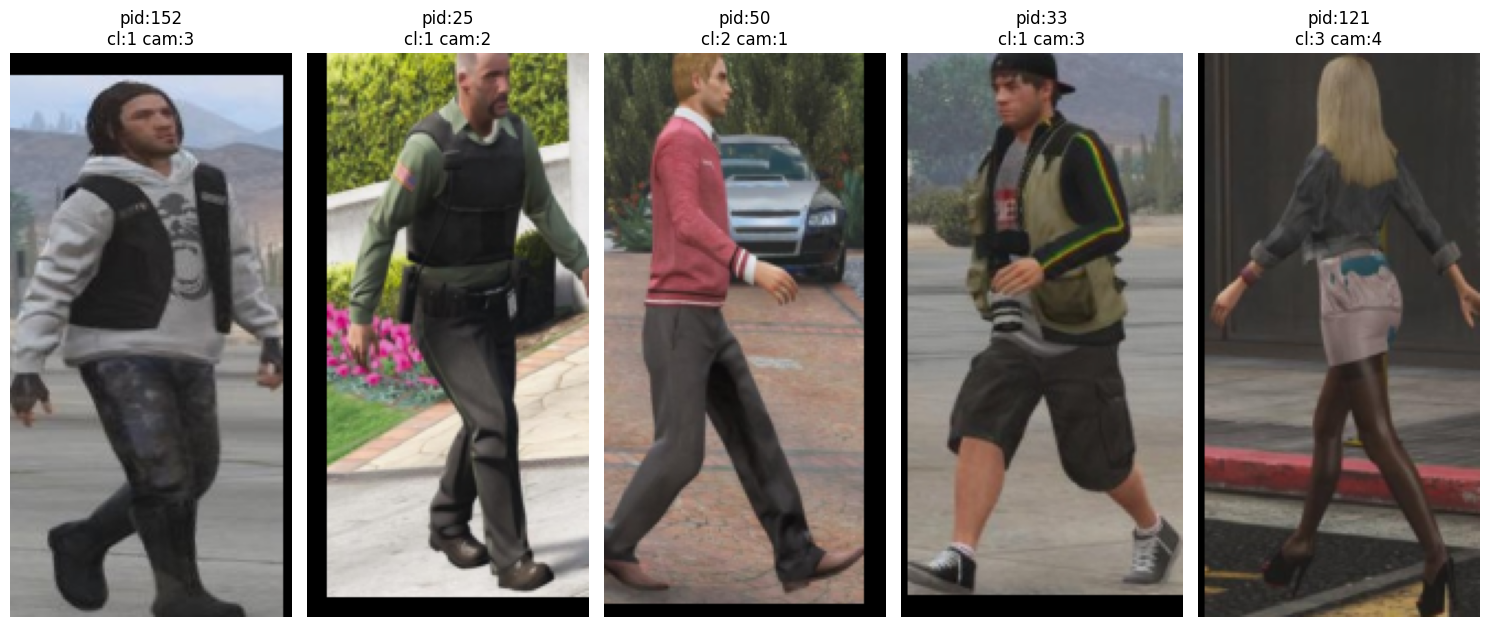

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Pobierz jeden batch z loadera
imgs_batch, pids_batch, cams_batch, clothes_batch = next(iter(train_loader))

# Normalizacja użyta w transformacjach
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


def unnormalize(tensor_img):
    # tensor_img: torch.Tensor C,H,W
    img = tensor_img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # H,W,C
    img = (img * std) + mean  # odwrócenie normalizacji
    img = np.clip(img, 0, 1)
    return img


# Ile przykładów wyświetlić
N = min(5, imgs_batch.size(0))

fig, axes = plt.subplots(1, N, figsize=(N * 3, 8))
if N == 1:
    axes = [axes]

for i in range(N):
    ax = axes[i]
    ax.imshow(unnormalize(imgs_batch[i]))
    ax.axis("off")
    ax.set_title(
        f"pid:{int(pids_batch[i])}\ncl:{int(clothes_batch[i])} cam:{int(cams_batch[i])}"
    )

plt.tight_layout()
plt.show()

In [5]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

from vc_clothes_data_module import VCClothesDataModule
from face_feature_extractor_module import FaceReIDModule


torch.set_float32_matmul_precision('medium')

# Ścieżka do danych
DATA_ROOT = "./data/vc_clothes"

# 1. DataModule
dm = VCClothesDataModule(root_dir=DATA_ROOT, batch_size=32, num_workers=11)

# Obliczamy liczbę klas dynamicznie (opcjonalnie)
# dm.setup()
# num_classes = len(set(dm.train_ds.pids))
# print(f"Liczba klas: {num_classes}")
num_classes = 256  # Wg definicji datasetu

# 2. Model
model = FaceReIDModule(num_classes=num_classes)

# 3. Trener
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc", mode="max", filename="face-reid-{epoch:02d}-{val_acc:.2f}"
)

trainer = Trainer(
    max_epochs=10,
    accelerator="auto",  # Automatycznie wykryje GPU
    devices=1,
    callbacks=[checkpoint_callback],
    # log_every_n_steps=10
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\25Z\GSN\projekt\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [6]:
trainer.fit(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | model     | FaceFeatureExtractor | 24.7 M | train | 0    
1 | criterion | CrossEntropyLoss     | 0      | train | 0    
-------------------------------------------------------------------
1.2 M     Trainable params
23.5 M    Non-trainable params
24.7 M    Total params
98.758    Total estimated model params size (MB)
158       Modules in train mode
0         Modules in eval mode
0         Total Flops


Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Epoch 9: 100%|██████████| 242/242 [01:44<00:00,  2.32it/s, v_num=51, train_loss_step=3.700, val_loss=4.180, val_acc=0.414, train_loss_epoch=3.980, train_acc=0.632]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 242/242 [01:44<00:00,  2.32it/s, v_num=51, train_loss_step=3.700, val_loss=4.180, val_acc=0.414, train_loss_epoch=3.980, train_acc=0.632]


In [7]:
trainer.test(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3


c:\25Z\GSN\projekt\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 32/32 [00:10<00:00,  2.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4637254774570465
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.4637254774570465}]

In [8]:
def evaluate_classification_metrics(model, dataloader, device):
    model.eval()
    model.to(device)

    correct_1 = 0
    correct_5 = 0
    correct_10 = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            _, pids, _, _, faces = batch

            faces = faces.to(device)
            pids = pids.to(device)

            logits = model(faces)

            _, pred_indices = logits.topk(k=10, dim=1)

            pids_reshaped = pids.view(-1, 1)

            matches = pred_indices == pids_reshaped

            correct_1 += matches[:, 0].sum().item()
            correct_5 += matches[:, :5].sum().item()
            correct_10 += matches[:, :10].sum().item()

            total += pids.size(0)

    r1 = correct_1 / total
    r5 = correct_5 / total
    r10 = correct_10 / total

    return r1, r5, r10

In [9]:
r1, r5, r10 = evaluate_classification_metrics(model, dm.test_dataloader(), DEVICE)

print("Final evaluation on test set:")
print(f"Rank-1 (test_acc): {r1:.2%}")
print(f"Rank-5  : {r5:.2%}")
print(f"Rank-10 : {r10:.2%}")

Final evaluation on test set:
Rank-1 (test_acc): 46.37%
Rank-5  : 69.02%
Rank-10 : 75.69%
